# ARIMA models

In the previous notebook, we worked with AR and MA models. Now, let's deepen our analysis to include differencing terms and complete our job in describing an ARIMA model. 

In [50]:
import sys
import logging

sys.path.append("../src/")

from utils import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.api as smt


%matplotlib inline

### Importing datasets

We will work with four different datasets in order to fix concepts. Let's work with all of them and test our assumptions in building a

In [29]:
df_elect_prod = pd.read_csv('../data/raw/Electric_Production.csv')
df_temp_sp = pd.read_csv('../data/raw/station_sao_paulo.csv')
df_fem_births = pd.read_csv('../data/raw/daily-total-female-births.csv')
df_google_stock = pd.read_csv('../data/raw/google_stock.csv')

## Stationarity and differencing

In order to avoid problems when dealing with time series models, we need to assure that our data is stationary. Intuitively, it simple means that we want to check if our history came from the same process. Thus, seasonal and trend series do not obey this property since they change over time. These restrictions do not apply to cyclic behavior.

For a process $ x_{t} $ to be stationary, we must have:
- $ E[x_{t}] = \mu $ := Constant mean over whole series
- $ VAR[x_{t}] = \sigma $ := Constant variance
- $ Cov(x_{t}, x_{t+h}) = f(h) \neq f(t) $ := The series does not have an abrupt change in its structure


Let's plot the series we choosed in order to check for stationarity.

In [30]:
# First, a little bit of preprocessing
df_elect_prod = (df_elect_prod
                 .rename(columns={'DATE':'date', 'IPG2211A2N':'elec_production'})
                 .set_index('date')
                 )

df_temp_sp = preprocess_climate_data(df_temp_sp)
df_fem_births = (df_fem_births
                 .rename(columns=str.lower)
                 .set_index('date')
                 )

df_google_stock = (df_google_stock
                     .rename(columns=str.lower)
                     .set_index('date')
                     )

INFO:utils:[get_only_month_columns(df)] n_obs=74 n_col=13 time=0:00:00.000291
INFO:utils:[remove_inconsistencies(df)] n_obs=74 n_col=13 time=0:00:00.008142


### Series plot

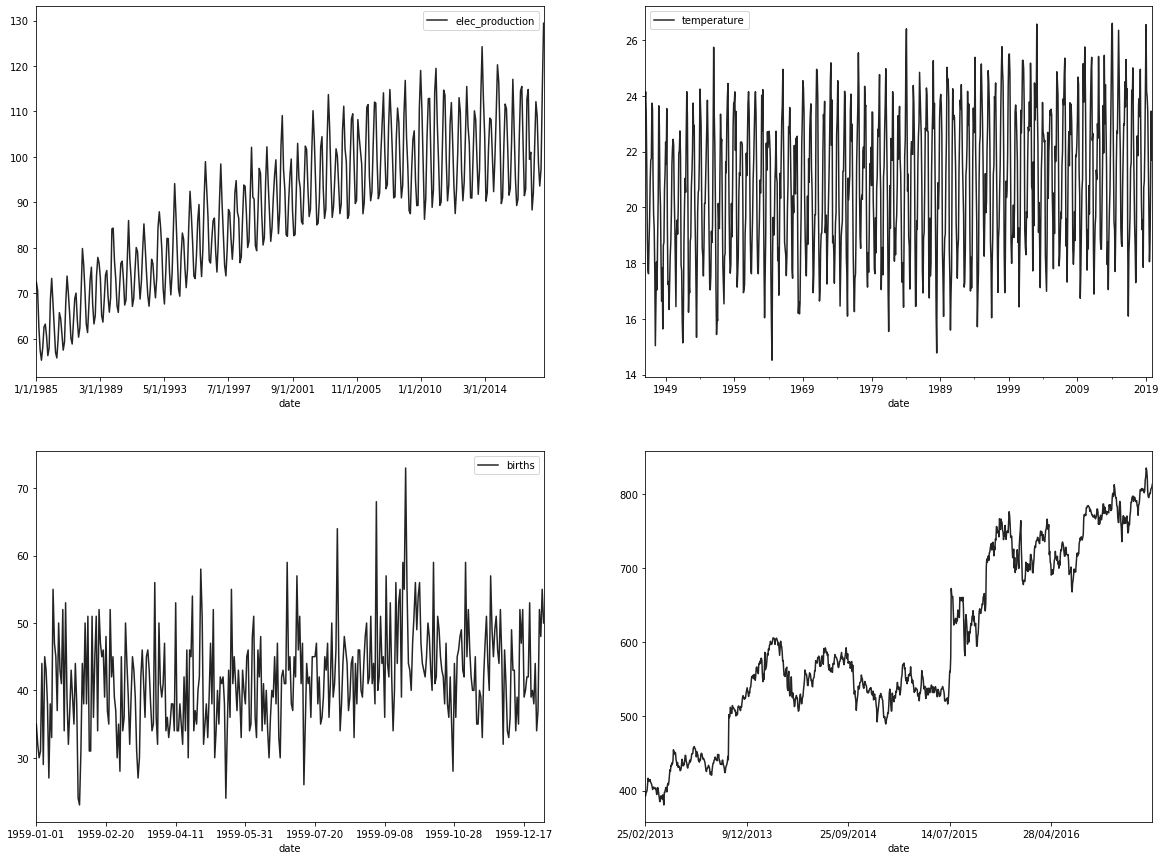

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.set_palette("autumn")
df_elect_prod.plot(ax=ax[0][0], label='Electricity Production')
df_temp_sp.plot(ax=ax[0][1], label="Temperature in SP")
df_fem_births.plot(ax=ax[1][0], label='N of female births')
df_google_stock['close'].plot(ax=ax[1][1], label='Close daily google stocks')

From above plot, we can assume the following:

 - Daily Female Birth dataset seems to be the unique stationary series.
 - Electricity Productions seems to have strong seasonal and trend factors as well as non constant variance.
 - Temperature has a strong seasonal factor, with likely a small linear upward trend.
 - Google daily stocks seems to have no seasonality, but a strong trend factor.

### ACF plot

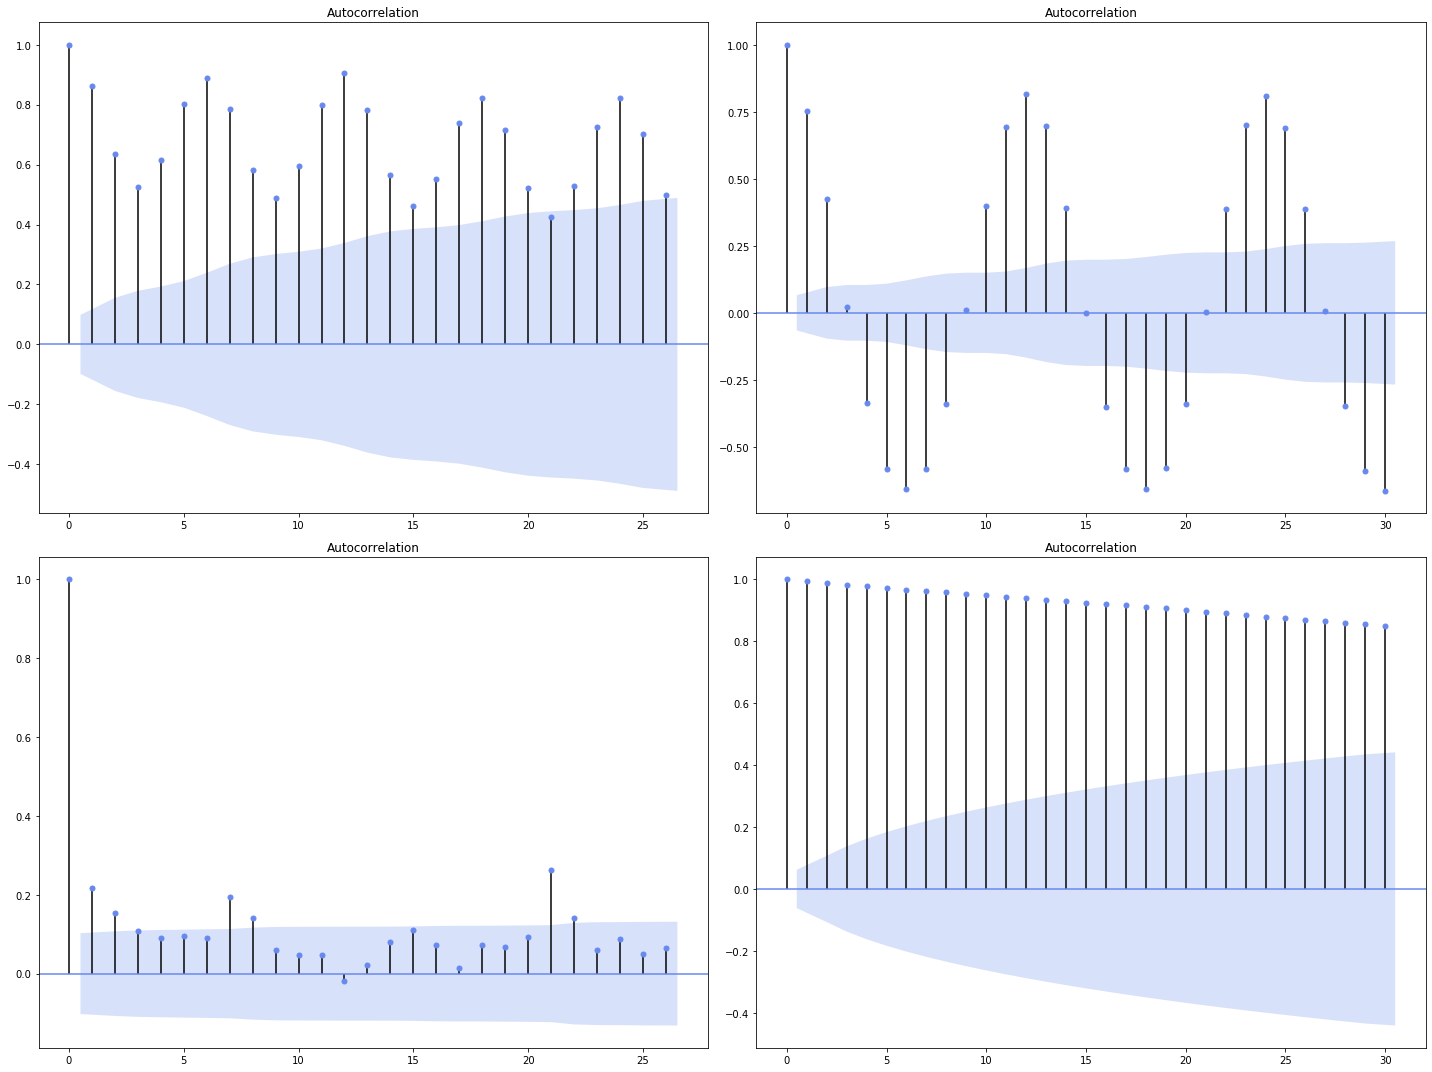

In [57]:
sns.set_palette('coolwarm')

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
smt.graphics.plot_acf(df_elect_prod, ax=ax[0][0])
smt.graphics.plot_acf(df_temp_sp, ax=ax[0][1])
smt.graphics.plot_acf(df_fem_births, ax=ax[1][0])
smt.graphics.plot_acf(df_google_stock['close'], ax=ax[1][1])

plt.tight_layout()

The Autocorrelation Function plots above are very characteristic of data with such properties such as trend, seasonality and stationary ones.
 - First, for electricity production, we have a strong seasonality and trend, indicating by autocorrelation coefficients decreasing to zero slowly and with peaks at the seasonal factors, at each 6/12/18 lags. Likely this is a semester/annual seasonal factor.
 - For the one with only a strong seasonality, we see the same results. The difference from the first plot is that we might not even have a trend since it seems to be a small contribution only.
 - Google stocks decreases slowly, typical of trend series.
 - And the last, female daily data we have a quick decrease to zero, although we have a few significant values above 95% confidence interval. We should check for it later.

### Making non-stationary series to be stationary

### Analyzing residuals and applying Unit root test to check for stationarity 

## Non-seasonal ARIMA models

Some useful notations:

 - ARIMA is defined as (AR order, differencing, MA order)

We learnt that we should check for a few properties of our series before doing any modelling. Since we are beginning with non-seasonal models, we will work with Female Daily Birth dataset.

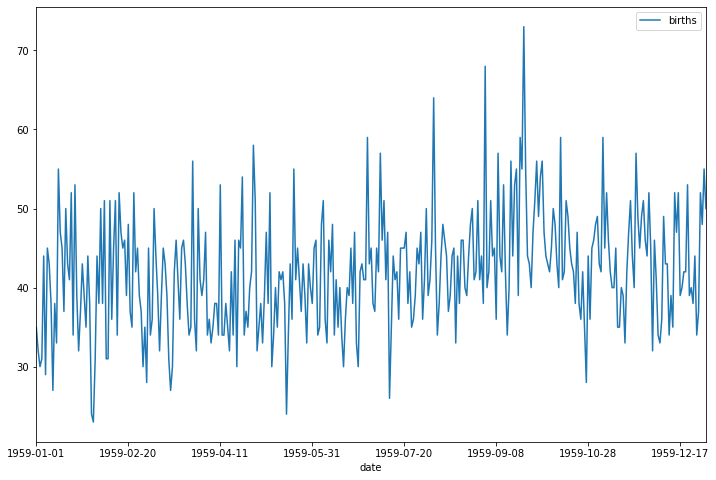

In [4]:
df_fem_births = df_fem_births.rename(columns=str.lower).set_index('date')
df_fem_births.plot(figsize=(12, 8))

Characteristics to consider first:

- There is no clear trend in our data.
- There is no clear  **seasonality** factor. 
- No apparent **outliers**
- No long-run **cycle**
- The variance does not increase overtime.
- No **abrupt changes**

From a first initial plot, it seems we do not need any additional transformation on data. 

As general guideline, in ACF and PACFs plots we are looking for:
 - We look for AR models in PACF plots generally. The ACF will tapper to zero somehow.
 - An AR(2) has a sinusoidal ACF that converges to 0
 - MA have theoretical ACFs with non-zero values.
 - ARMA models (including both AR and MA terms) have ACFs and PACFs that both tail off to 0.
 
Before doing our analysis in the female birth dataset, let explore acf and pacf plots for simple MA, AR and ARMA models.

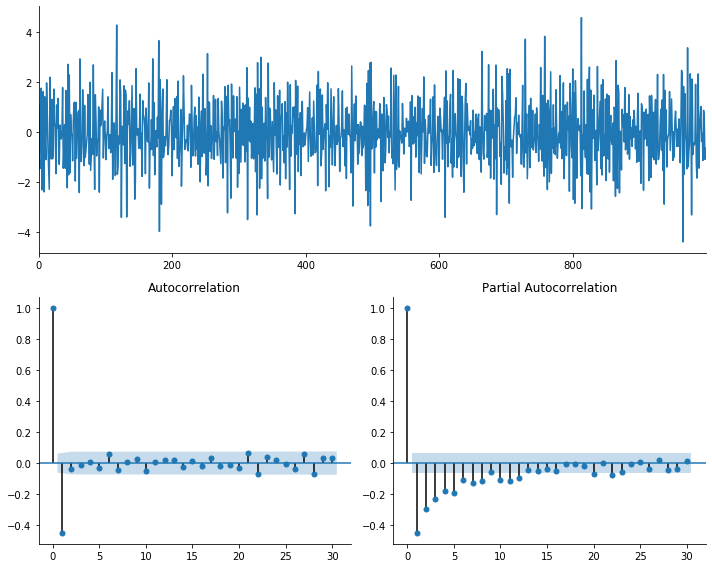

In [33]:
from statsmodels.tsa.arima_process import ArmaProcess

def plot_arma_process(ar_parameters=(1, 0), ma_parameters=(1, 0)):
    
    ar_1 = np.array(ar_parameters)
    ma_1 = np.array(ma_parameters)
    ma_object_1 = ArmaProcess(ar_1, ma_1).generate_sample(nsample=1000)
    tsplot(pd.Series(ma_object_1));
    
plot_arma_process(ma_parameters=(1, -0.9))

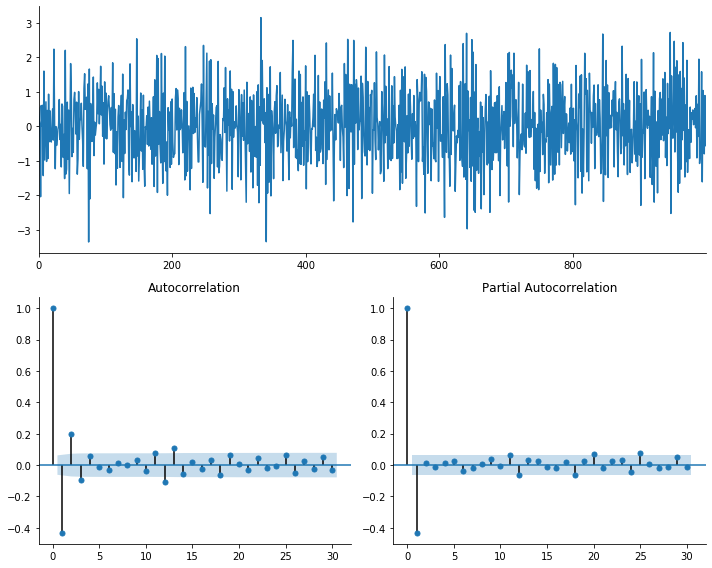

In [34]:
plot_arma_process(ar_parameters=(1, 0.4))

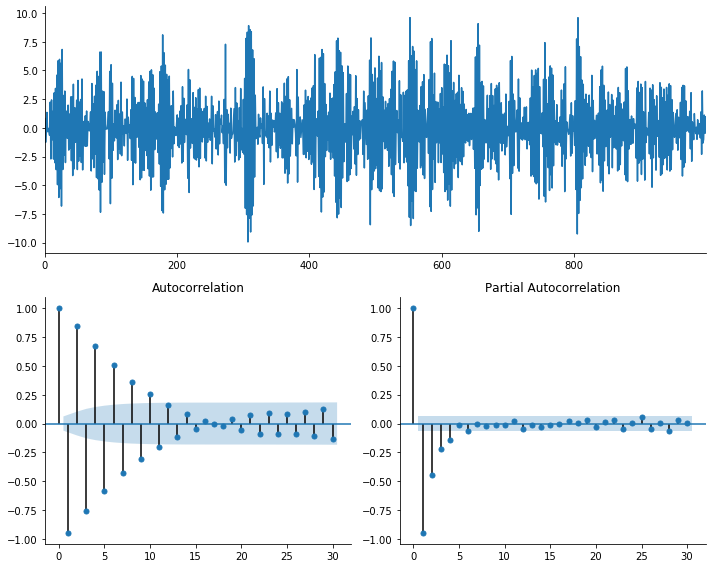

In [40]:
plot_arma_process(ar_parameters=(1, 0.9),
                  ma_parameters=(1, -0.5))

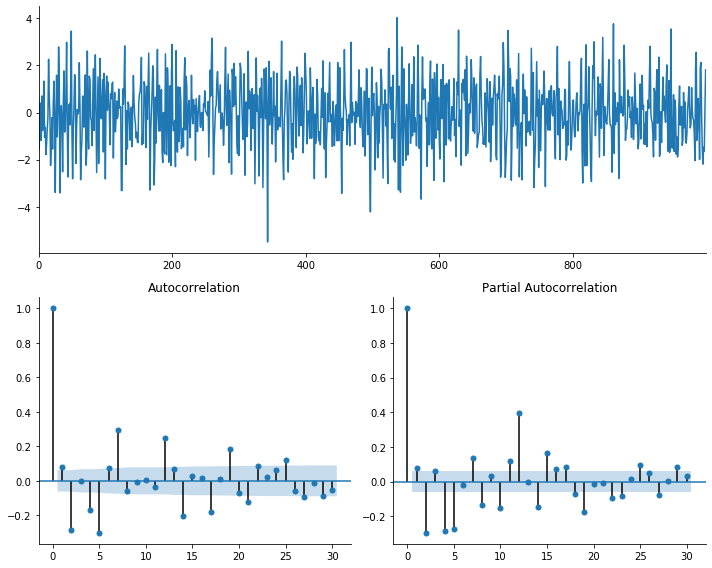

In [80]:
plot_arma_process(ar_parameters=(1, 0, 0.2, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, -0.4),
                  ma_parameters=(1, 0, 0, 0, -.3, 0, 0, 0.5))

We can see the patterns discussed previouls yon above plots. Now, let's work with real data.

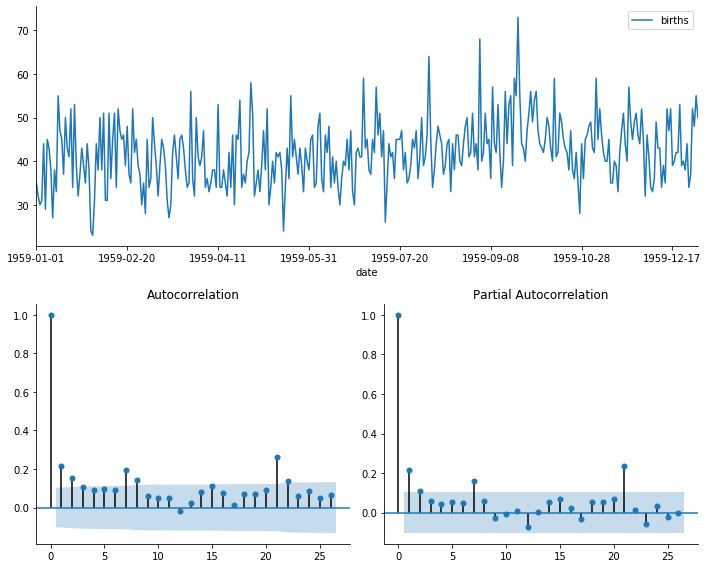

In [43]:
tsplot(df_fem_births);

We can also use an auto arima function to test which model fits better in our data. Later, we will compare both results in a train/test validation.

In [227]:
import pmdarima as pm

model_auto = pm.auto_arima(train, max_p=30, seasonal=False, suppress_warnings=True)
fitted_model = model_auto.fit(train)

In [228]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -891.598
Date:                Sat, 22 Feb 2020   AIC                           1789.196
Time:                        20:04:28   BIC                           1799.924
Sample:                             0   HQIC                          1793.507
                                - 265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0274      0.015      1.807      0.071      -0.002       0.057
ma.L1         -0.9757      0.021    -45.643      0.000      -1.018      -0.934
sigma2        49.6583      4.224     11.755      0.000      41.379      57.938
===================================================================================
Ljung-Box (Q):                       42.95   Jarque-Bera (JB):                10.62
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.46
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
arma_forecast = model_arma.forecast(steps=100)[0]
auto_forecast = fitted_model.predict(n_periods=100)

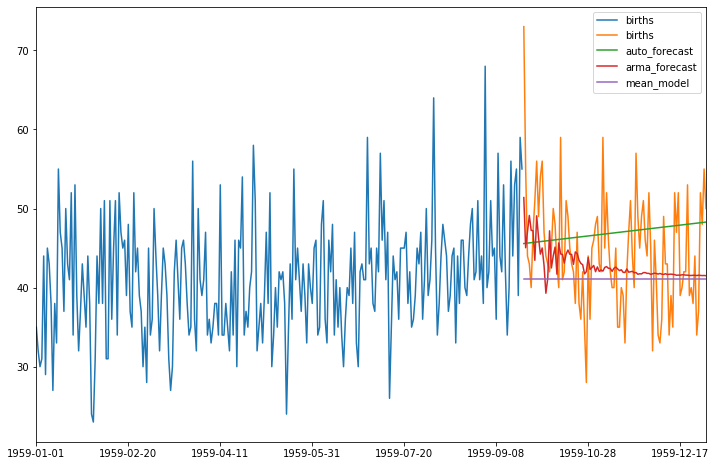

In [202]:
pd.concat([train, 
           test, 
           pd.Series(auto_forecast, index=test.index, name='auto_forecast'),
           pd.Series(arma_forecast, index=test.index, name='arma_forecast'),
           pd.Series(np.mean(train).values[0], index=test.index, name='mean_model')], 
          axis=1, sort=False).plot(figsize=(12, 8))

In [210]:


print("MSE for ARMA model: {} - AUTO-ARIMA model: {} - MEAN model: {}".format(mean_squared_error(test, arma_forecast), 
                                                                              mean_squared_error(test, auto_forecast),
                                                                              mean_squared_error(test, pd.Series(np.mean(train.values), index=test.index))))
#print("MAE for ARMA model: {} - AUTO-ARIMA model: {}".format(mean_absolute_error(test, arma_forecast), mean_absolute_error(test, auto_forecast)))

MSE for ARMA model: 45.79106813390608 - AUTO-ARIMA model: 58.59296738369199 - MEAN model: 60.316605909576346


That is interesting! Even though we have a auto arima library, the one obtained using PACF plot intuition had a better result overall.

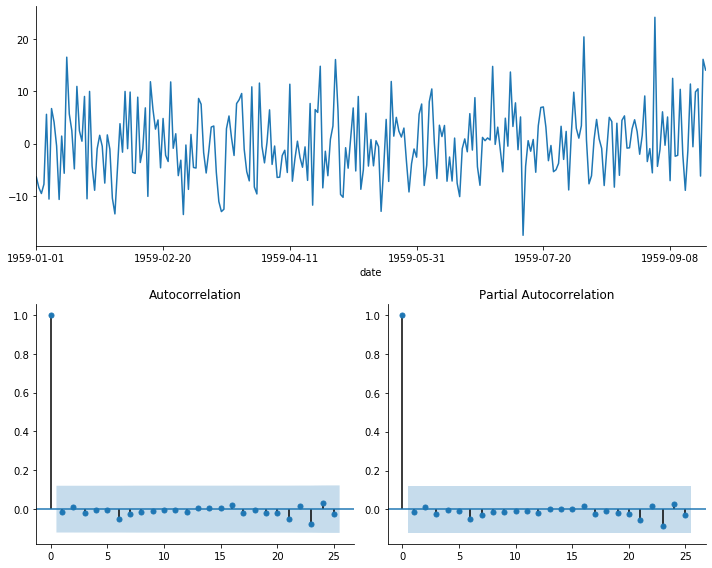

In [220]:
tsplot(pd.Series(model_arma.resid));

The residual plot seems good enough, no autocorrelations between the errors, indicating our model is capturing really well the structure.

In [230]:
from statsmodels.tsa import arima_model

model_arma = arima_model.ARIMA(train, order=(21, 0, 1)).fit()
model_arma.summary()

/home/v086200/anaconda3/envs/applied-ts/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 births   No. Observations:                  265
Model:                    ARMA(21, 1)   Log Likelihood                -883.322
Method:                       css-mle   S.D. of innovations              6.754
Date:                Sat, 22 Feb 2020   AIC                           1814.644
Time:                        20:12:08   BIC                           1900.558
Sample:                    01-01-1959   HQIC                          1849.163
                         - 09-22-1959                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            41.4640      1.301     31.879      0.000      38.915      44.013
ar.L1.births      0.2146      0.225      0.954      0.341      -0.226       0.656
ar.L2.births      0.0387      0.064      0.606      0.545      -0.086       0.164
ar.L3.births      0.0325      0.063      0.521      0.603      -0.090       0.155
ar.L4.births      0.0479      0.063      0.758      0.449      -0.076       0.172
ar.L5.births      0.0342      0.062      0.549      0.583      -0.088       0.156
ar.L6.births      0.0247      0.063      0.391      0.696      -0.099       0.148
ar.L7.births      0.1401      0.063      2.209      0.028       0.016       0.264
ar.L8.births      0.1041      0.070      1.477      0.141      -0.034       0.242
ar.L9.births      0.0528      0.069      0.767      0.444      -0.082       0.188
ar.L10.births     0.0195      0.065      0.300      0.764      -0.108       0.147
ar.L11.births    -0.0276      0.064     -0.428      0.669      -0.154       0.099
ar.L12.births    -0.0788      0.064     -1.226      0.221      -0.205       0.047
ar.L13.births    -0.0604      0.067     -0.895      0.372      -0.193       0.072
ar.L14.births    -0.0338      0.065     -0.519      0.604      -0.161       0.094
ar.L15.births     0.0388      0.064      0.603      0.547      -0.087       0.165
ar.L16.births    -0.0029      0.065     -0.045      0.964      -0.130       0.124
ar.L17.births    -0.0906      0.065     -1.400      0.163      -0.218       0.036
ar.L18.births     0.0085      0.068      0.126      0.900      -0.124       0.141
ar.L19.births     0.0159      0.065      0.244      0.807      -0.111       0.143
ar.L20.births     0.0032      0.065      0.049      0.961      -0.125       0.131
ar.L21.births     0.2597      0.067      3.866      0.000       0.128       0.391
ma.L1.births     -0.1499      0.233     -0.644      0.520      -0.606       0.306
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0334           -0.0000j            1.0334           -0.0000
AR.2             1.0260           -0.2599j            1.0584           -0.0395
AR.3             1.0260           +0.2599j            1.0584            0.0395
AR.4             0.8648           -0.6154j            1.0614           -0.0984
AR.5             0.8648           +0.6154j            1.0614            0.0984
AR.6             0.6748           -0.7955j            1.0431           -0.1380
AR.7             0.6748           +0.7955j            1.0431            0.1380
AR.8             0.3752           -0.9966j            1.0649           -0.1927
AR.9             0.3752           +0.9966j            1.0649            0.1927
AR.10           -1.0714           -0.1646j            1.0839           -0.4757
AR.

## Season ARIMA models

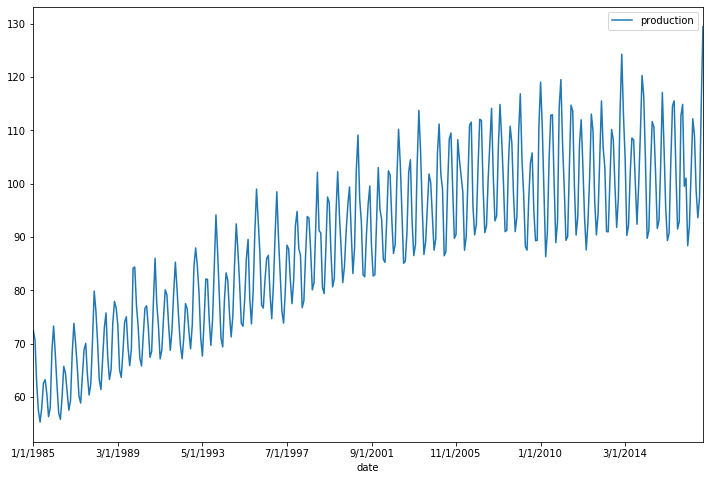

In [11]:
ax = df_elect_prod.plot(figsize=(12, 8))

Characteristics to consider first:

- There is a trend in our dataset, but it is not likely to be a linear one since in the last years it seemed to be stable.
- There is a strong **seasonality** factor. 
- No apparent **outliers**
- No long-run **cycle**
- The variance seems to increase slightly overtime.
- No **abrupt changes**

Let's do different acf plots for this series, but taking differences, log to get constant variance and so on.

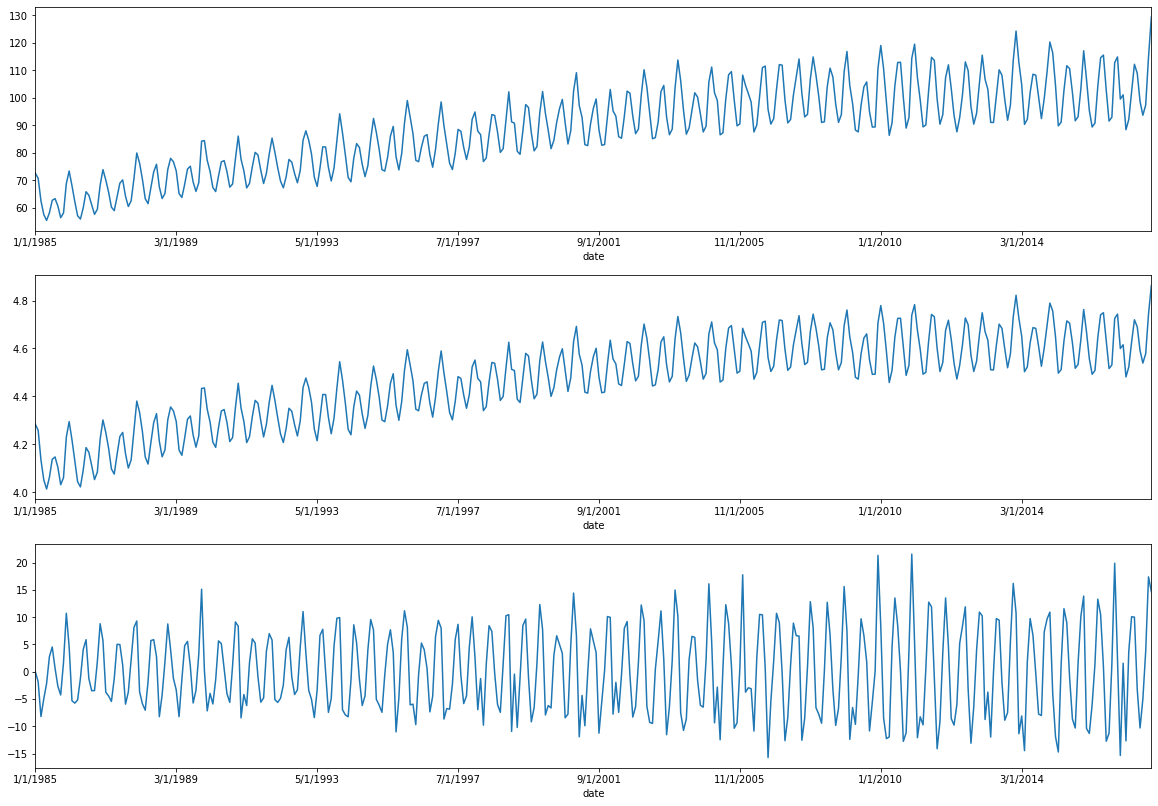

In [12]:
df_elect_prod['production_log'] = np.log(df_elect_prod['production'])
df_elect_prod['production_diff_1'] = df_elect_prod['production'].diff(1).fillna(0)

fig, ax = plt.subplots(3, 1, figsize=(20, 14))

df_elect_prod['production'].plot(ax=ax[0])
df_elect_prod['production_log'].plot(ax=ax[1])
df_elect_prod['production_diff_1'].plot(ax=ax[2])

Now, acf plots for each one.

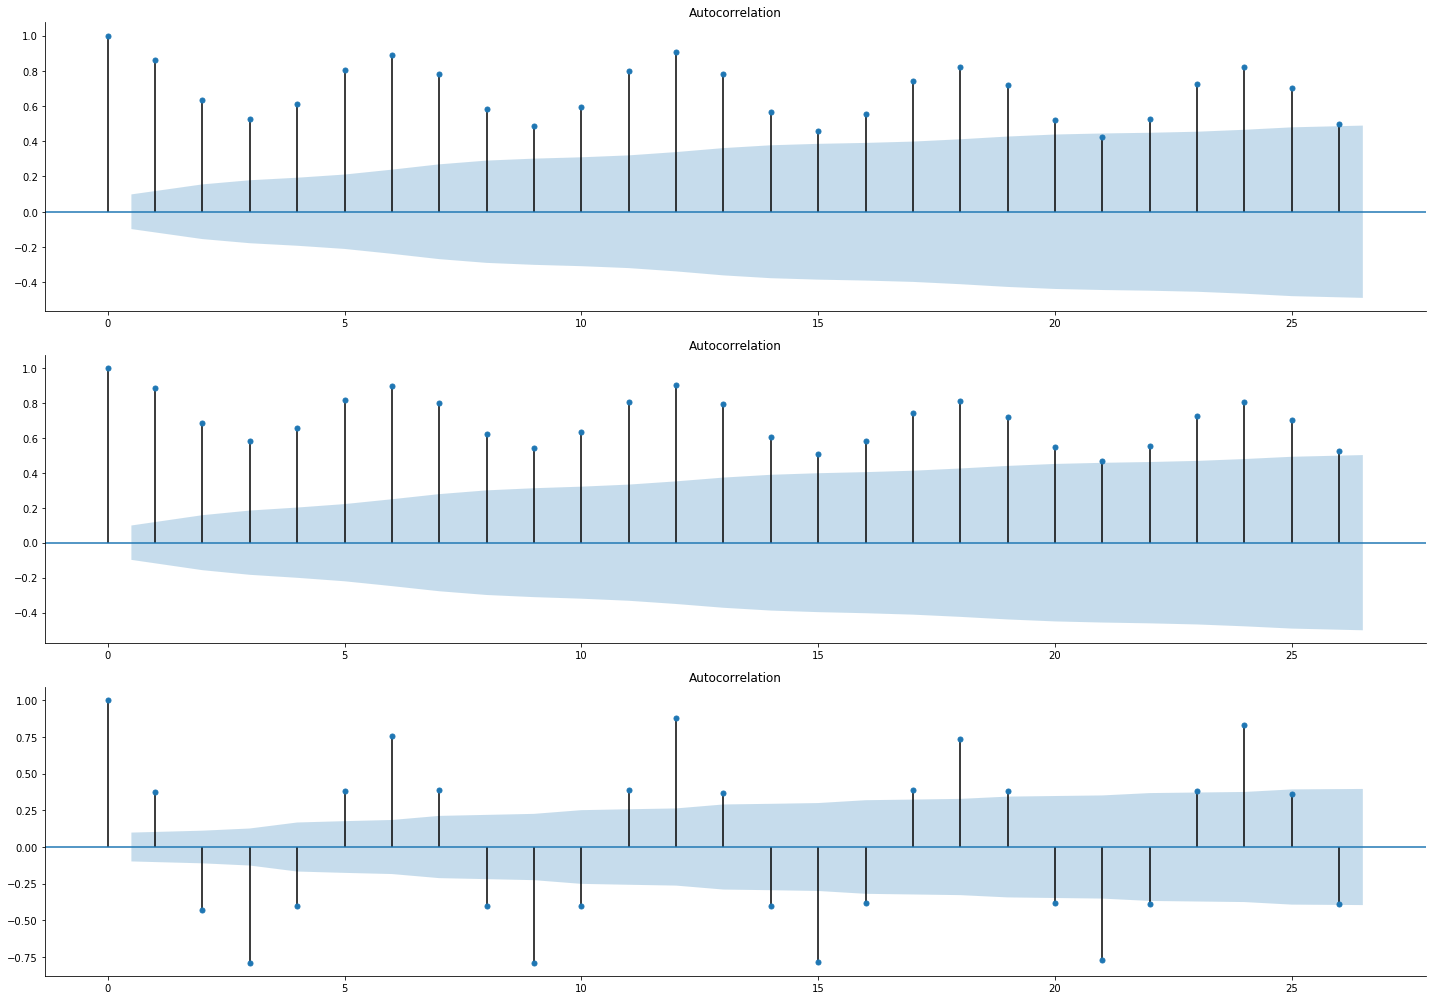

In [14]:
import statsmodels.tsa.api as smt

fig, ax = plt.subplots(3, 1, figsize=(20, 14))

smt.graphics.plot_acf(df_elect_prod['production'], ax=ax[0])
smt.graphics.plot_acf(df_elect_prod['production_log'], ax=ax[1])
smt.graphics.plot_acf(df_elect_prod['production_diff_1'], ax=ax[2])

sns.despine()
plt.tight_layout()

In the first two plots, acf patterns does not trails off two zero, indicating that series has a trend which we did take into account, and that is true. For the differenced series, we can see that the series is still not stationary, because we have a clearly seasonal pattern, which repeats itself for each 7 values, probably due a  seasonality. Let's difference again, considering 12 diff value.

In [15]:
df_elect_prod['production_diff_12'] = df_elect_prod['production'].diff(12).fillna(0)

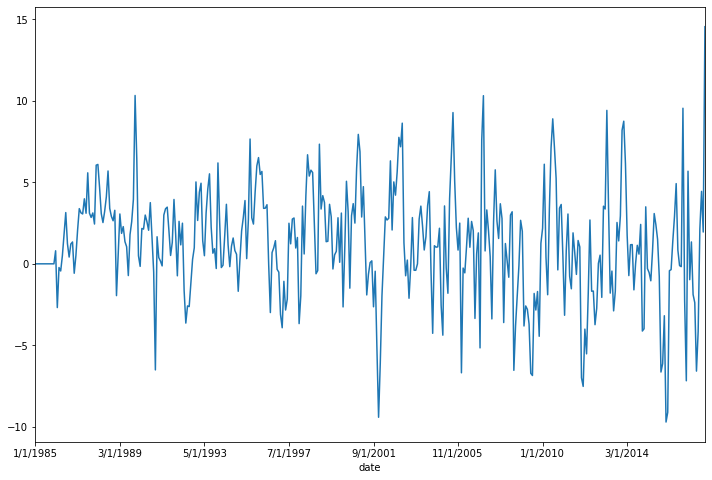

In [16]:
df_elect_prod['production_diff_12'].plot(figsize=(12, 8))

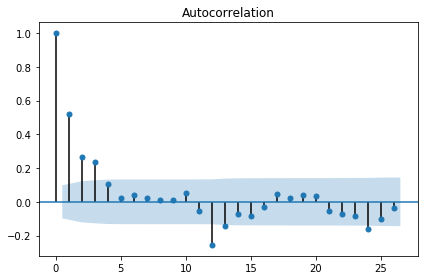

In [17]:
smt.graphics.plot_acf(df_elect_prod['production_diff_12'])

plt.tight_layout()

Let's plot the lag values for this series.

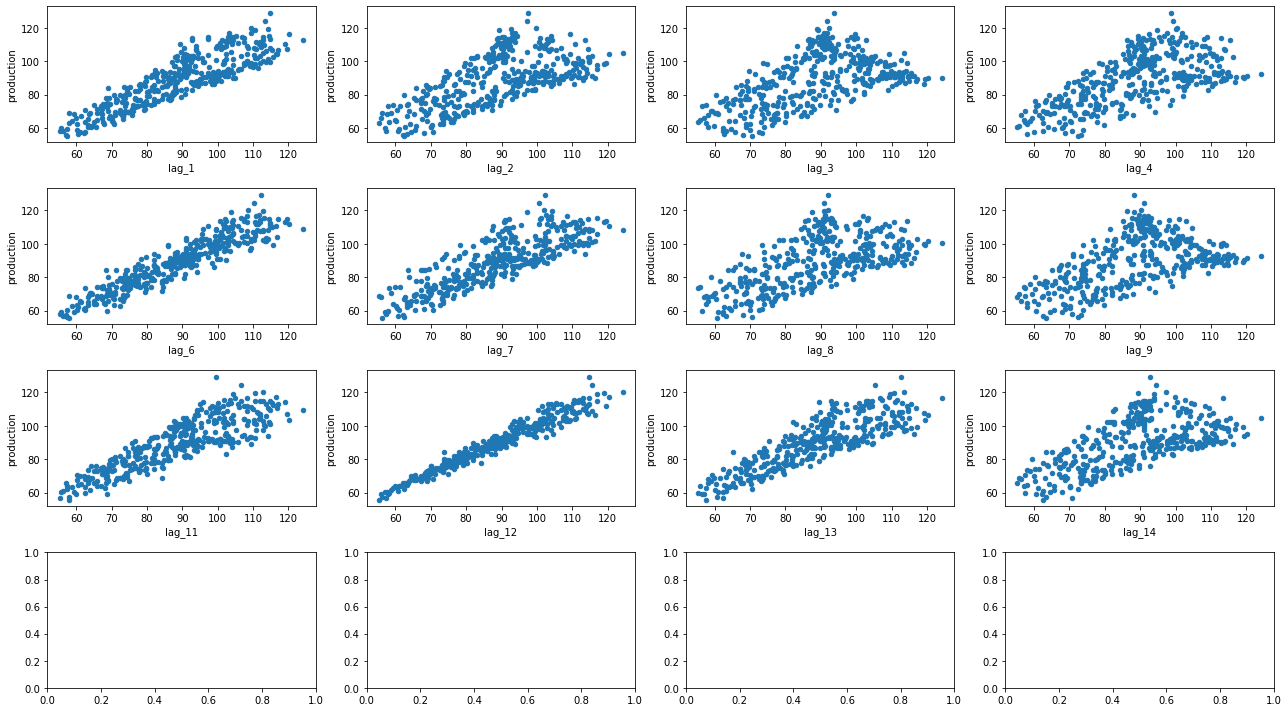

In [111]:
def compute_lag_features(df, variable=None, lags=10):
    for lag in range(1, lags):
        df.loc[:, 'lag_' + str(lag)] = df[variable].shift(lag)
        
    return df

def plot_scatter_lags(df, variable, lags=12):
    fig, axes = plt.subplots(4, 4, figsize=(18, 10))
    
    j = 0
    for row in range(axes.shape[0]-1):
        for col in range(axes.shape[1]):
            df.plot(y=variable,
                    x='lag_' + str(row+1+j),
                    kind='scatter',
                    ax=axes[row][col])
            
            j += 1
            
    plt.tight_layout()
            
df_elect_prod = compute_lag_features(df_elect_prod, variable='production', lags=15)
plot_scatter_lags(df_elect_prod, variable='production')

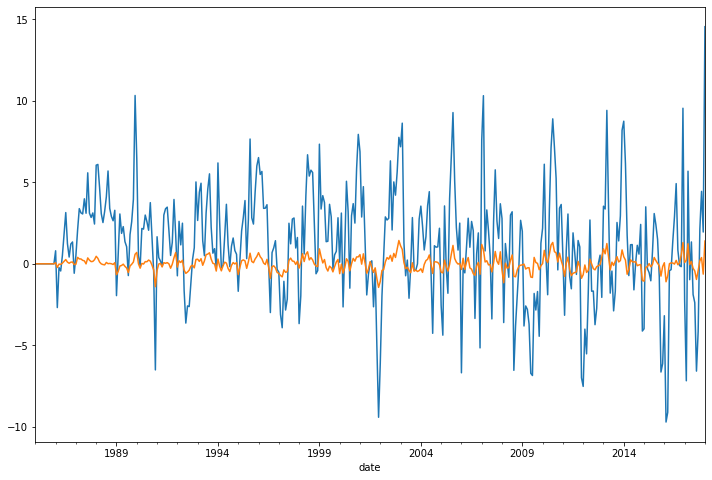

In [115]:
df_elect_prod['production_diff_12'].plot(figsize=(12, 8))
df_elect_prod['production_diff_12_diff_1'].rolling('365D').mean().plot(figsize=(12, 8))

As we can see above, we have the strongest correlation when lag=12, indicating a annual seasonality factor in our data. Now let's do a time series decompostion.

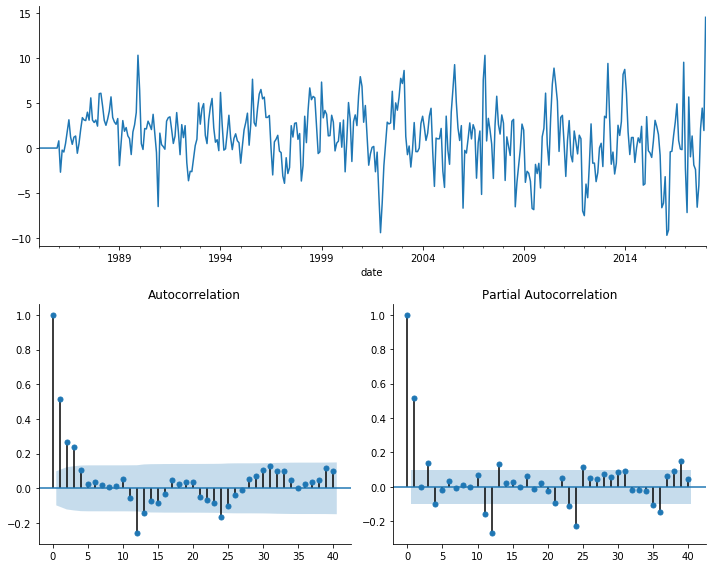

In [111]:
df_elect_prod['production_diff_12_diff_1'] = df_elect_prod['production_diff_12'].diff().fillna(0)
tsplot(df_elect_prod['production_diff_12'], lags=40);

In [134]:
import statsmodels.api as sm

non_seasonal_order = (3, 1, 2)
seasonal_order = (0, 1, 1, 12)

model_sarima = sm.tsa.SARIMAX(df_elect_prod['production'], order=non_seasonal_order, seasonal_order=seasonal_order)

/home/v086200/anaconda3/envs/applied-ts/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [135]:
fitted_model = model_sarima.fit()

/home/v086200/anaconda3/envs/applied-ts/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/v086200/anaconda3/envs/applied-ts/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [136]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         production   No. Observations:                  397
Model:             SARIMAX(3, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -886.805
Date:                            Mon, 24 Feb 2020   AIC                           1787.610
Time:                                    12:30:58   BIC                           1815.264
Sample:                                01-01-1985   HQIC                          1798.579
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1615      0.569      0.284      0.776      -0.953       1.276
ar.L2          0.1184      0.320      0.370      0.711      -0.508       0.745
ar.L3          0.0559      0.085      0.658      0.510      -0.111       0.222
ma.L1         -0.5537      0.570     -0.971      0.331      -1.671       0.563
ma.L2         -0.3832      0.537     -0.713      0.476      -1.436       0.670
ma.S.L12      -0.7480      0.036    -20.910      0.000      -0.818      -0.678
sigma2         5.7473      0.346     16.632      0.000       5.070       6.425
===================================================================================
Ljung-Box (Q):                       56.41   Jarque-Bera (JB):                26.24
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               3.00   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(45, 125)

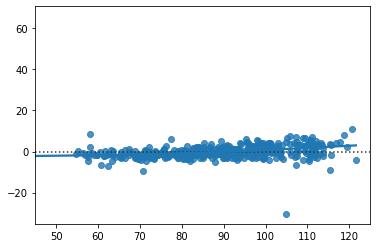

In [140]:
ax = sns.residplot(x=fitted_model.fittedvalues.values,
              y=fitted_model.resid.values,
             lowess=True)

ax.set_xlim(45, 125)

In [167]:
train, test = train_test_split(df_elect_prod['production'], train_size=265)

In [150]:
model_sarima = sm.tsa.SARIMAX(train, order=non_seasonal_order, seasonal_order=seasonal_order)
fitted_model = model_sarima.fit()

/home/v086200/anaconda3/envs/applied-ts/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


2007-02-01    105.838120
2007-03-01    100.483902
2007-04-01     90.835307
2007-05-01     92.025618
2007-06-01    101.114750
                 ...    
2015-01-01    125.560594
2015-02-01    118.972354
2015-03-01    113.913814
2015-04-01    103.933590
2015-05-01    105.168432
Freq: MS, Length: 100, dtype: float64

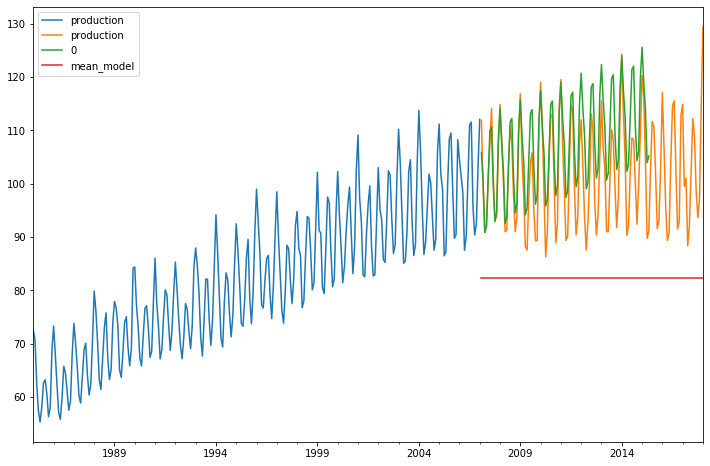

In [166]:
sarima_forecast = fitted_model.forecast(100)

pd.concat([train, 
           test, 
           sarima_forecast,#pd.Series(sarima_forecast, index=test.index, name='sarima_forecast'),
           #pd.Series(arma_forecast, index=test.index, name='arma_forecast'),
           pd.Series(np.mean(train), index=test.index, name='mean_model')], 
           axis=1, sort=False).plot(figsize=(12, 8))

In [157]:
pd.concat([train, 
           test, 
           pd.Series(sarima_forecast, index=test.index, name='sarima_forecast'),
           #pd.Series(arma_forecast, index=test.index, name='arma_forecast'),
           pd.Series(np.mean(train), index=test.index, name='mean_model')], 
          axis=1, sort=False)

,production,production,sarima_forecast,mean_model
date,,,,
1985-01-01,72.5052,NaN,NaN,NaN
1985-02-01,70.6720,NaN,NaN,NaN
1985-03-01,62.4502,NaN,NaN,NaN
1985-04-01,57.4714,NaN,NaN,NaN
1985-05-01,55.3151,NaN,NaN,NaN
...,...,...,...,...
2017-09-01,NaN,98.6154,NaN,82.266519
2017-10-01,NaN,93.6137,NaN,82.266519
2017-11-01,NaN,97.3359,NaN,82.266519


In [156]:
sarima_forecast

1993-05-01     70.630034
1993-06-01     74.206675
1993-07-01     80.787434
1993-08-01     81.617371
1993-09-01     76.809159
                 ...    
2006-09-01    100.812879
2006-10-01     90.049681
2006-11-01     93.286219
2006-12-01    107.287676
2007-01-01    110.094918
Freq: MS, Length: 165, dtype: float64

In [119]:
import pmdarima as pm

model_auto = pm.auto_arima(df_elect_prod['production'], seasonal=True, m=12, suppress_warnings=True)
fitted_model = model_auto.fit(df_elect_prod['production'])

/home/v086200/anaconda3/envs/applied-ts/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (1, 1, 2)x(2, 0, 2, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


In [120]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, 1, 12)   Log Likelihood                -926.336
Date:                            Mon, 24 Feb 2020   AIC                           1866.672
Time:                                    12:19:05   BIC                           1894.542
Sample:                                         0   HQIC                          1877.713
                                            - 397                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.431      0.667      -0.002       0.003
ar.L1          0.3496      0.089      3.915      0.000       0.175       0.525
ma.L1         -0.7168      0.087     -8.198      0.000      -0.888      -0.545
ma.L2         -0.2270      0.078     -2.916      0.004      -0.379      -0.074
ar.S.L12       0.9923      0.005    189.767      0.000       0.982       1.003
ma.S.L12      -0.7334      0.042    -17.463      0.000      -0.816      -0.651
sigma2         5.8559      0.337     17.393      0.000       5.196       6.516
===================================================================================
Ljung-Box (Q):                       66.96   Jarque-Bera (JB):                26.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<matplotlib.axes._subplots.AxesSubplot at 0x7fae05715750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fae05707090>)

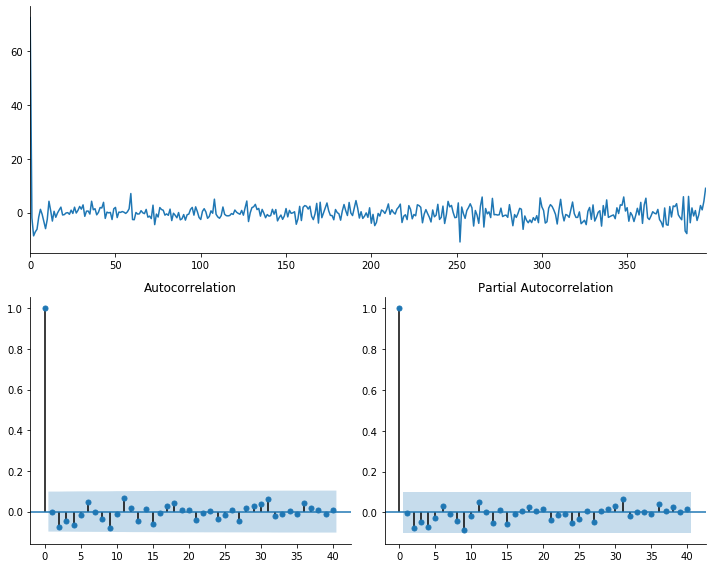

In [126]:
tsplot(pd.Series(fitted_model.resid()), lags=40)#.plot(figsize=(12, 8))

In [32]:
df_elect_prod['month'] = pd.to_datetime(df_elect_prod.index).month
df_elect_prod['year'] = pd.to_datetime(df_elect_prod.index).year

In [33]:
df_elect_prod_pivoted = df_elect_prod.pivot_table(index='year', columns='month', values='production')

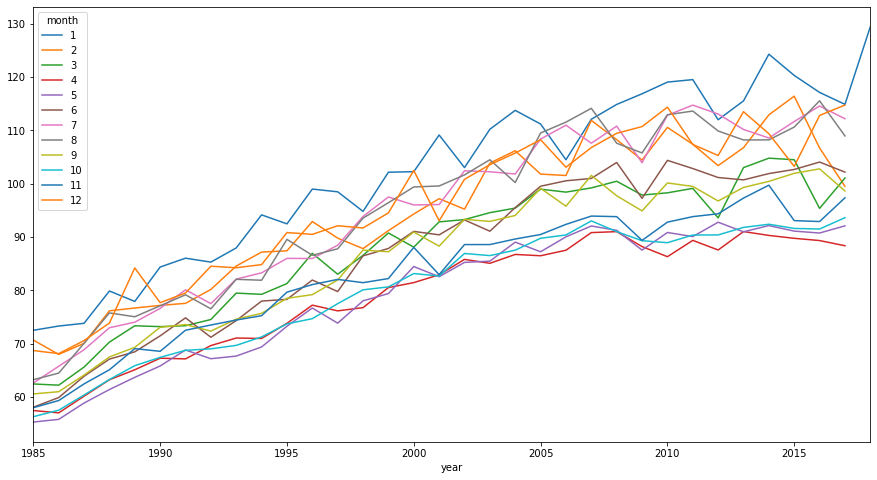

In [36]:
df_elect_prod_pivoted.plot(figsize=(15, 8))

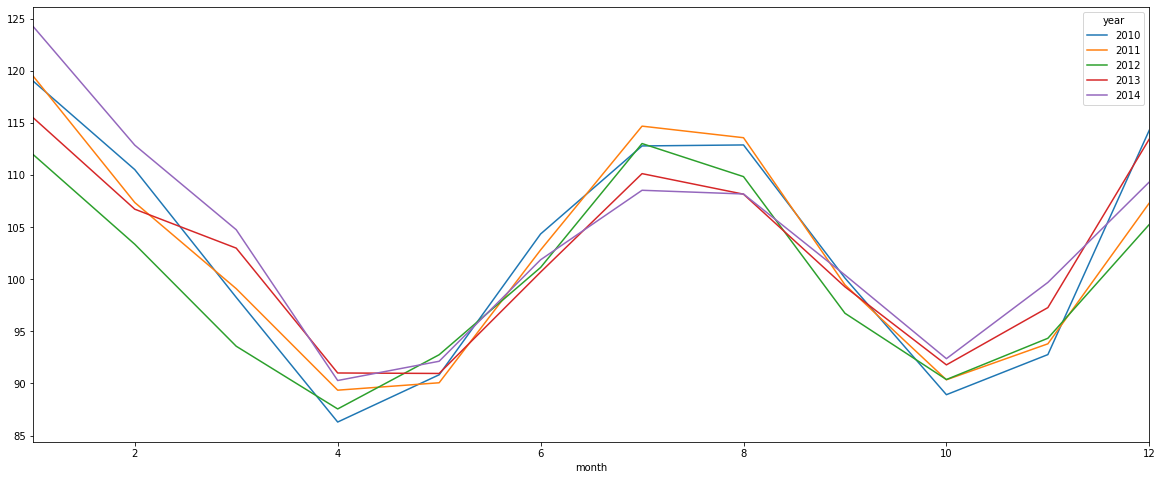

In [44]:
df_elect_prod_pivoted.T[[2010, 2011, 2012, 2013, 2014]].plot(figsize=(20, 8))

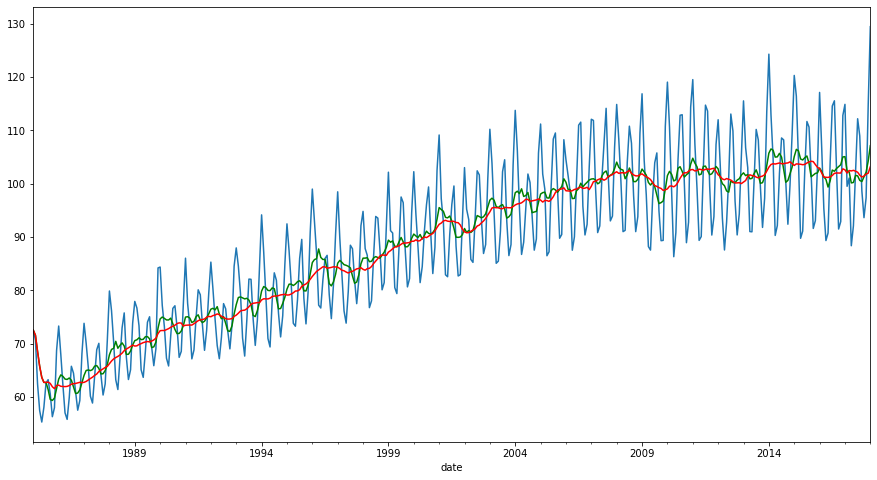

In [64]:
fig, ax = plt.subplots(figsize=(15, 8))

df_elect_prod.index = pd.to_datetime(df_elect_prod.index)

df_elect_prod['production'].plot(label='raw data', ax=ax)
#df_elect_prod['production'].rolling('7D').mean().plot(color='red', ax=ax)
df_elect_prod['production'].rolling('183D').mean().plot(color='green', ax=ax)
df_elect_prod['production'].rolling('365D').mean().plot(color='red', ax=ax)

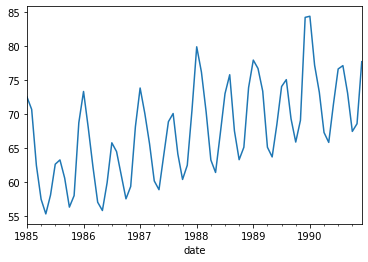

In [71]:
df_elect_prod.loc['1985':'1990', 'production'].plot()